<div style="display:flex">
    <img src="https://bse.eu/sites/default/files/bse_logo_small.png" alt="Logo 1">
</div>

# Traffic Signs Detection: Dataset Preparation

### Import Libraries and Setup

In [4]:
# Importing Libraries
import os
import cv2
import glob
import torch
import shutil
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style='darkgrid')
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Video

from tqdm.notebook import trange, tqdm

import yaml
from ultralytics import YOLO

import warnings
warnings.filterwarnings('ignore')

# Setting the random seed for reproducibility
random.seed(42)
np.random.seed(42)

To investigate the dataset, we will first check that there are no mismatches between images and labels, then understand how the labelling system works and how its paired to the images, and visualize some examples.  Additionally, we can check the classes distribution

### Utilities functions

In [1]:
# Function to display an image with its bounding boxes
def display_image_with_boxes(image_path, label_file, include_label=True):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the label file
    with open(label_file, 'r') as file:
        labels = file.readlines()

    # Draw bounding boxes on the image
    for label in labels:
        parts = label.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        
        # Convert YOLO format to pixel coordinates
        img_height, img_width, _ = image.shape
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Put class ID text
        if include_label:
            cv2.putText(image, class_names[str(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show() 

In [2]:
# Function to get the label file path from the image path
def get_label_file(image_path):
    # Replace 'images' with 'labels' in the path
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
    return label_path

In [6]:
# Set the directory paths
path= os.getcwd()
Image_dir = os.path.join(path, 'data', 'train', 'images')
image_files = os.listdir(Image_dir)

Understand how labels are structured and paired with images

Labels for FisheyeCamera_1_00076_png.rf.c1649fd1ef9e95ffa77a31dcffb825ed.jpg:
0 0.3641826923076923 0.41346153846153844 0.015625 0.009615384615384616
7 0.36778846153846156 0.5456730769230769 0.006009615384615385 0.008413461538461538
1 0.4495192307692308 0.5024038461538461 0.006009615384615385 0.003605769230769231


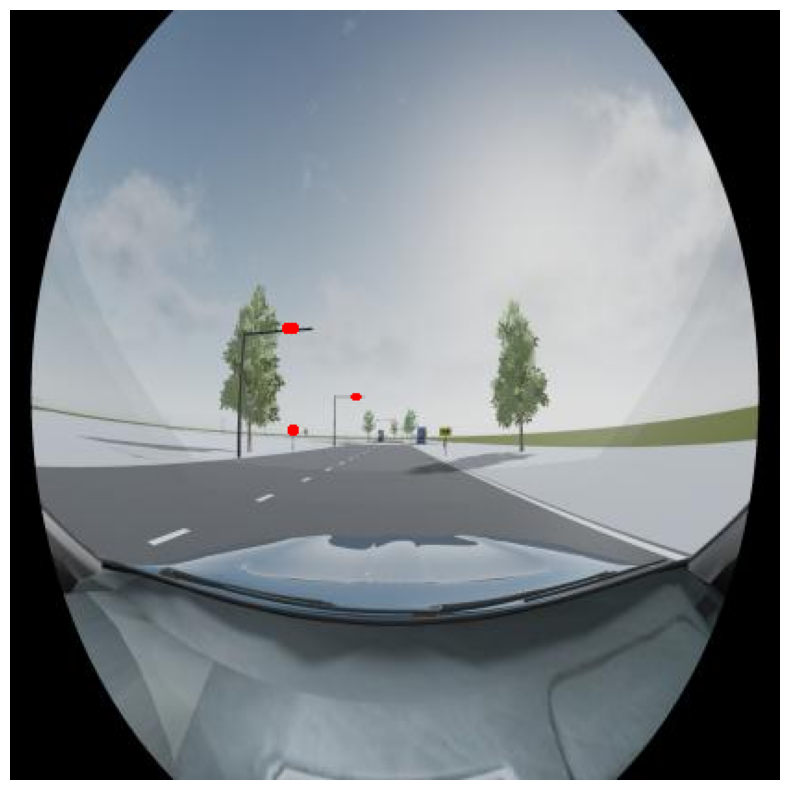

In [7]:
# Get a random image and its corresponding label file
random_image_path = os.path.join(Image_dir, random.choice(image_files))
label_file = get_label_file(random_image_path)

# Read the label file
if os.path.exists(label_file):
    with open(label_file, 'r') as file:
        labels = file.readlines()
    print(f"Labels for {os.path.basename(random_image_path)}:")
    for label in labels:
        print(label.strip())
else:
    print(f"No label file found for {os.path.basename(random_image_path)}")
# Display a random image with its bounding boxes

display_image_with_boxes(random_image_path, label_file, include_label=False)


As we can observe, labels are not in natural languange, but rather encoded in an intengers list. Let's further investigate on that, and create a dictionary the class numbers (6) to natural language labels (speed limit 20), using the information on the kaggle dataset

In [8]:
# get a set of all image labels (only the number of the class)
labels = set()
for image in image_files:
    label_file = get_label_file(os.path.join(Image_dir, image))
    if os.path.exists(label_file):
        with open(label_file, 'r') as file:
            for line in file:
                class_id = line.strip().split()[0]
                labels.add(class_id)

# Convert the set to a sorted list
labels = sorted(labels)
# Display the unique labels
print(f"Unique labels found in the dataset: {labels}")

Unique labels found in the dataset: ['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
class_names = {'0': 'Green Light', '1': 'Red Light', '2': 'Speed Limit 10',   '3': 'Speed Limit 100', '4': 'Speed Limit 110', '5': 'Speed Limit 120', '6': 'Speed Limit 20', '7': 'Speed Limit 30', '8': 'Speed Limit 40', '9': 'Speed Limit 50', '10': 'Speed Limit 60', '11': 'Speed Limit 70', '12': 'Speed Limit 80', '13': 'Speed Limit 90', '14': 'Stop'}
# define a updated class names where we skip speed limit 10
class_names_updated = { '0': 'Green Light', '1': 'Red Light', '2': 'Speed Limit 100', '3': 'Speed Limit 110', '4': 'Speed Limit 120', '5': 'Speed Limit 20', '6': 'Speed Limit 30', '7': 'Speed Limit 40', '8': 'Speed Limit 50', '9': 'Speed Limit 60', '10': 'Speed Limit 70', '11': 'Speed Limit 80', '12': 'Speed Limit 90', '13': 'Stop'}

Let's now verify that these label names are correct (we can re run the following code chunk multiple times to assert this)

Labels for 00002_00017_00008_png.rf.958d92ad47742185bf2850483fb42da9.jpg:
9 0.5120192307692307 0.4795673076923077 0.6177884615384616 0.6430288461538461


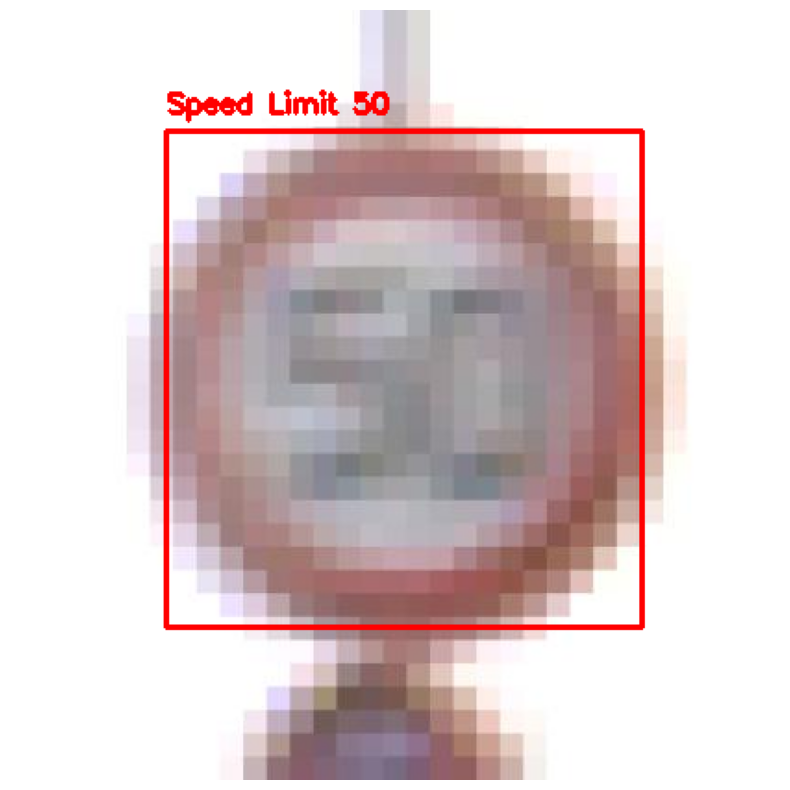

In [9]:
# Get a random image and its corresponding label file
random_image_path = os.path.join(Image_dir, random.choice(image_files))
label_file = get_label_file(random_image_path)

# Read the label file
if os.path.exists(label_file):
    with open(label_file, 'r') as file:
        labels = file.readlines()
    print(f"Labels for {os.path.basename(random_image_path)}:")
    for label in labels:
        print(label.strip())
else:
    print(f"No label file found for {os.path.basename(random_image_path)}")


# Display a random image with its bounding boxes
display_image_with_boxes(random_image_path, label_file)

In [10]:
# Count total amount of train, val and test images (+ labels)
train_images = os.listdir(Image_dir)
train_labels = os.listdir(os.path.join(path, 'data', 'train', 'labels'))
print(f'Total number of training images: {len(train_images)}')
print(f'Total number of training labels: {len(train_labels)}\n')

val_images = os.listdir(os.path.join(path, 'data', 'valid', 'images'))
val_labels = os.listdir(os.path.join(path, 'data', 'valid', 'labels'))
print(f'Total number of validation images: {len(val_images)}')    
print(f'Total number of validation labels: {len(val_labels)}\n')   

test_images = os.listdir(os.path.join(path, 'data', 'test', 'images'))
test_labels = os.listdir(os.path.join(path, 'data', 'test', 'labels'))

print(f'Total number of test images: {len(test_images)}')
print(f'Total number of test labels: {len(test_labels)}')

Total number of training images: 3530
Total number of training labels: 3530

Total number of validation images: 801
Total number of validation labels: 801

Total number of test images: 638
Total number of test labels: 638


Check Image shape

In [11]:
# Get the size of a random image
random_image_path = os.path.join(Image_dir, random.choice(image_files))

# Load the image
image = cv2.imread(random_image_path)

# Get the size of the image
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 416x416 and 3 channels.


Plot some random images

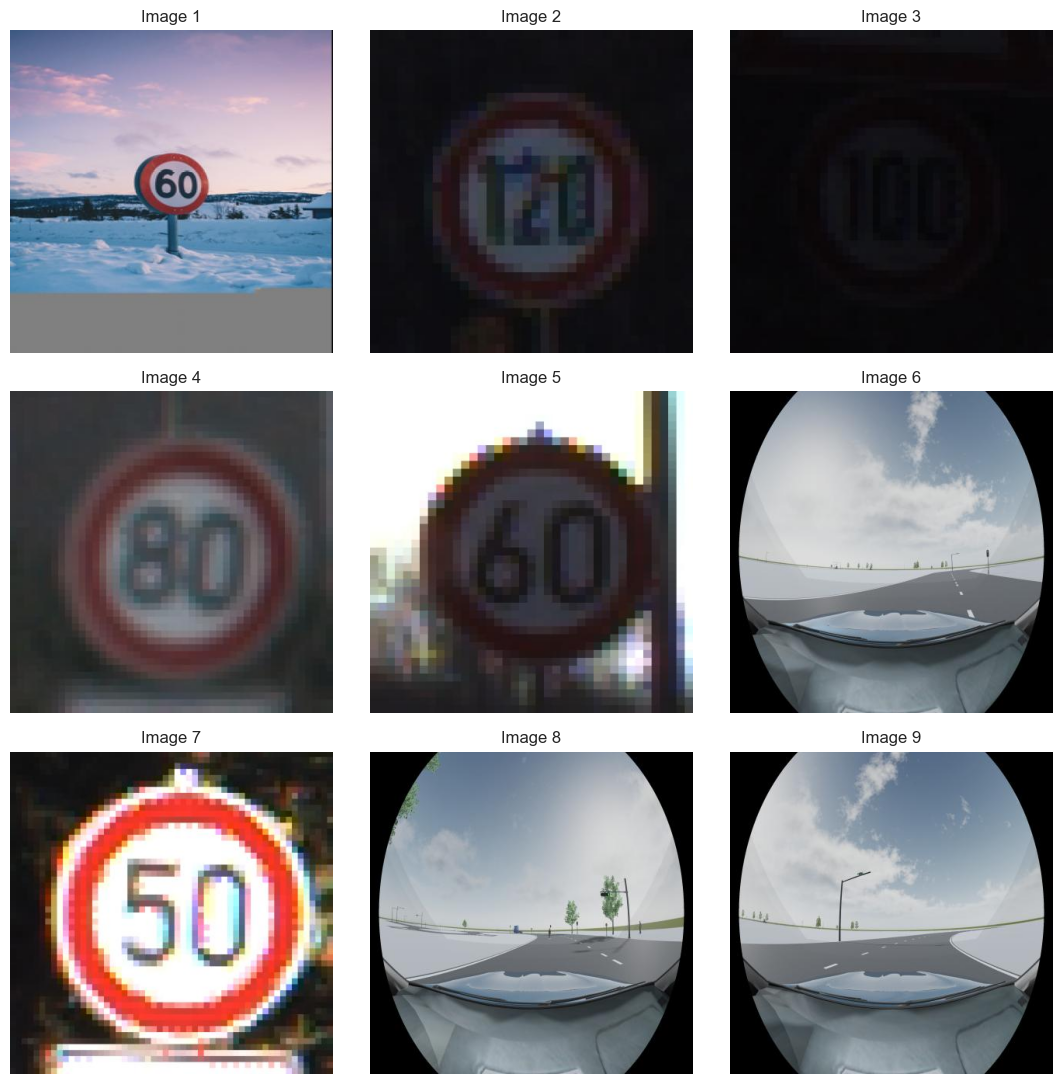

In [12]:
num_samples = 9

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Looking good! Now we have a pretty good idea of how the images are structured. Let's look at the image distribution before we can move on to training end evaluating our models 

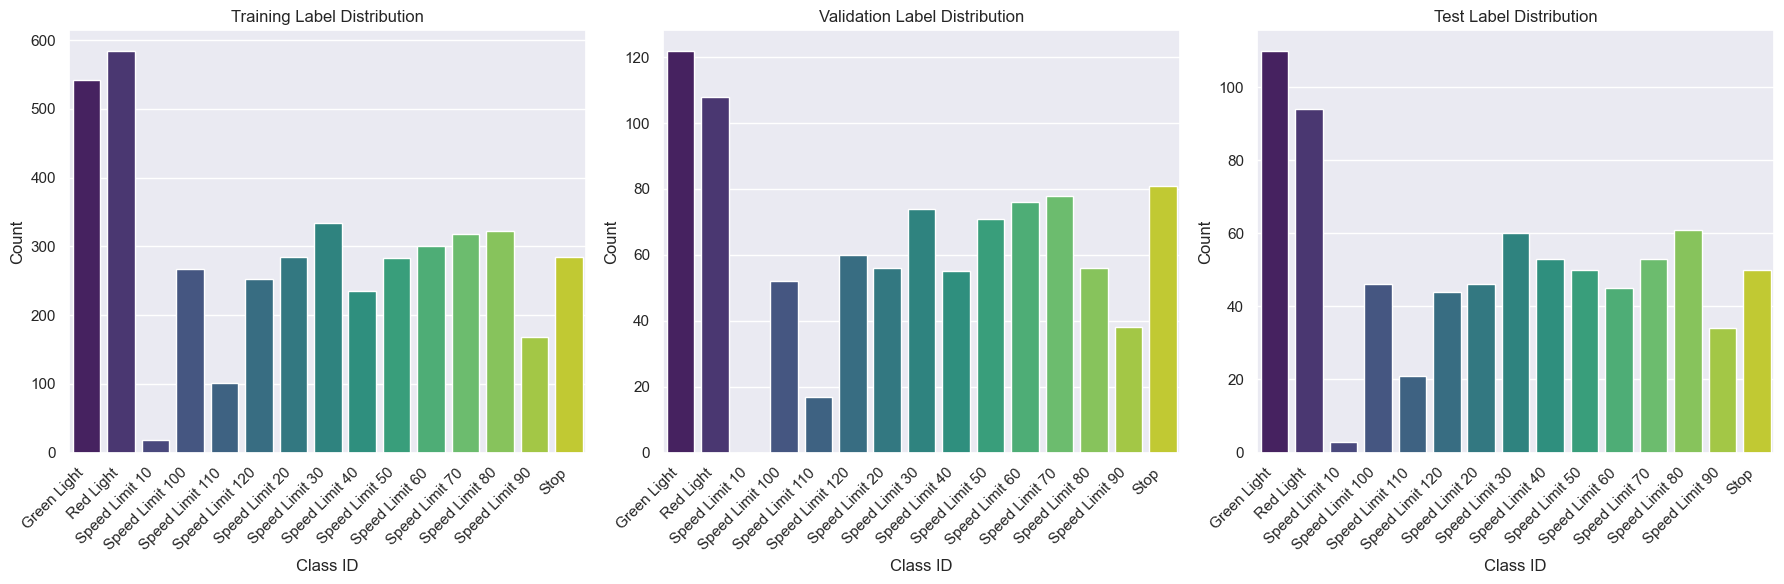

In [13]:
# train
train_label_counts = {label: 0 for label in class_names.values()} 
for label_file in train_labels:
    with open(os.path.join(path, 'data', 'train', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            train_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
train_label_counts_df = pd.DataFrame(list(train_label_counts.items()), columns=['Class ID', 'Count'])

# Validation
val_label_counts = {label: 0 for label in class_names.values()}
for label_file in val_labels:
    with open(os.path.join(path, 'data', 'valid', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            val_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
val_label_counts_df = pd.DataFrame(list(val_label_counts.items()), columns=['Class ID', 'Count'])   

# Test
test_label_counts = {label: 0 for label in class_names.values()}
for label_file in test_labels:
    with open(os.path.join(path, 'data', 'test', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            test_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
test_label_counts_df = pd.DataFrame(list(test_label_counts.items()), columns=['Class ID', 'Count'])


# Create three subplots for train, validation, and test label distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, df, title in zip(axes,
                         [train_label_counts_df, val_label_counts_df, test_label_counts_df],
                         ['Training', 'Validation', 'Test']):
    sns.barplot(x='Class ID', y='Count', data=df, ax=ax, palette='viridis')
    ax.set_title(f'{title} Label Distribution')
    ax.set_xlabel('Class ID')
    ax.set_ylabel('Count')
    # rotate the labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

We can observe some very dispare class distribution, yet there is some sort of consistency across the different datasets (train, val, test). Below are a few considerations:
- Given the extreme class imbalance of Speed Limit 10, we decide to drop it. We will however keep Speed Limit 110 as it is a significantly imbalanced class which can perhaps help deliver a valuable Error Analysis later. 
- To tackle the class imbalance, we could **switch the classification head to Focal Loss**, which is a provided option for YOLOv8. 
- It is also interesting to allow for class-specific confidence thresholds at inference time, to further account for the class imbalance. 

### Few-Shot Dataset Creation

We create a function that has as parameters the percentage of data that we want to use and the distribution (label_counts_df) of our traning data. Additionally we have an skip_classes parameter that allows to drop any class we want, in this case we will drop class # 2 because if the extreme class imbalance

Let's create the dataset used for the few-show training of our YOLOv8 classification model. To do so, here are a few considerations to bear in mind in the design:
- We keep the same (approx.) distribution of labels as in the full train dataset, excluding the `Speed Limit 10` label. 
- When selecting the images, we use those that have only the specific class we are looking for (no multi-label images)

In [ ]:
def create_few_shot_dataset(path, percentage, label_counts_df, skip_classes=None):
    Image_dir = os.path.join(path, 'data', 'train', 'images')
    label_dir = os.path.join(path, 'data', 'train', 'labels')
    train_labels = os.listdir(label_dir)

    # Create few-shot directories
    few_shot_data_dir = os.path.join(path, f'data/few_shot_{int(percentage*100)}pct')
    few_shot_img_dir = os.path.join(few_shot_data_dir, 'images')
    few_shot_lbl_dir = os.path.join(few_shot_data_dir, 'labels')
    os.makedirs(few_shot_img_dir, exist_ok=True)
    os.makedirs(few_shot_lbl_dir, exist_ok=True)

    # Convert label counts into a dict: {'0': 542, '1': 585, ...}
    label_counts_dict = {str(i): row['Count'] for i, row in label_counts_df.iterrows()}

    if skip_classes is None:
        skip_classes = []

    def copy_few_shot_images(class_id, num_images):
        matching = []
        for lf in train_labels:
            lbl_path = os.path.join(label_dir, lf)
            with open(lbl_path) as f:
                lines = [line.strip() for line in f if line.strip()]
                if lines and all(line.split()[0] == class_id for line in lines):
                    matching.append(lf)

        if len(matching) < num_images:
            print(f"Warning: not enough examples for class {class_id}, requested {num_images}, found {len(matching)}")
            num_images = len(matching)

        for lf in random.sample(matching, num_images):
            img_name = lf.replace('.txt', '.jpg')
            shutil.copy(os.path.join(Image_dir, img_name), os.path.join(few_shot_img_dir, img_name))
            shutil.copy(os.path.join(label_dir, lf), os.path.join(few_shot_lbl_dir, lf))

    # Process all classes
    for class_id, total_count in label_counts_dict.items():
        if class_id in skip_classes:
            continue
        few_shot_count = max(1, int(total_count * percentage))
        copy_few_shot_images(class_id, few_shot_count)

    print(f"Few-shot dataset created with {len(os.listdir(few_shot_img_dir))} images at {percentage*100}%")

Note that before training, we need to create a .yaml file. This a custom ultralytics YOLO dataset configuration in which we define the dataset root directory, relative paths to training and validation a a dictionary of class names